In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
data=pd.read_csv("./Ali_Baba_Stock_Data.csv")
data.head(5)

,Date,Adj Close,Close,High,Low,Open,Volume
0,2014-09-19,90.673950,93.889999,99.699997,89.949997,92.699997,271879400
1,2014-09-22,86.810966,89.889999,92.949997,89.500000,92.699997,66657800
2,2014-09-23,84.184128,87.169998,90.480003,86.620003,88.940002,39009800
3,2014-09-24,87.467667,90.570000,90.570000,87.220001,88.470001,32088000
4,2014-09-25,85.874191,88.919998,91.500000,88.500000,91.089996,28598000


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2617 entries, 0 to 2616
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2617 non-null   object 
 1   Adj Close  2617 non-null   float64
 2   Close      2617 non-null   float64
 3   High       2617 non-null   float64
 4   Low        2617 non-null   float64
 5   Open       2617 non-null   float64
 6   Volume     2617 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 143.2+ KB


特征工程

In [4]:
data["Date"]=pd.to_datetime(data["Date"])
data.set_index("Date",inplace=True)

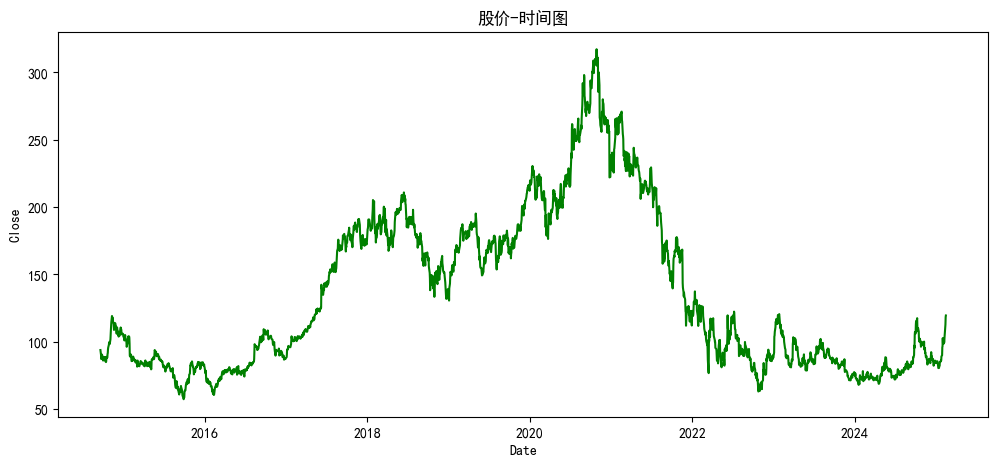

In [5]:
plt.figure(figsize=(12,5))
sns.lineplot(x="Date",y="Close",data=data,color="green")
plt.title("股价-时间图")
plt.show()

In [6]:
x=data.drop(["Close"],axis=1)
y=data["Close"]
ss=StandardScaler()
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)
x_train=ss.fit_transform(x_train)
x_test=ss.transform(x_test)

检验数据的平稳性

In [7]:
from statsmodels.tsa.stattools import adfuller  
result = adfuller(data["Close"])  
print("ADF Statistic:", result[0])  
print("p-value:", result[1])  
if result[1]<0.05:
    print("平稳")
else:
    print("不平稳！")

ADF Statistic: -1.3595506887082927
p-value: 0.6015071789226748
不平稳！


In [8]:
data["Close_diff"] = data["Close"].diff().dropna()
from statsmodels.tsa.stattools import adfuller
result = adfuller(data["Close_diff"].dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])
if result[1]<0.05:
    print("平稳了！")
else:
    print("还是不平稳")

ADF Statistic: -10.83412777115863
p-value: 1.6788719818614855e-19
平稳了！


使用AutoArima

In [9]:
!pip install pmdarima
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore") 
model_auto = auto_arima(data["Close"], 
                        seasonal=False,  
                        stepwise=True,   
                        suppress_warnings=True,
                        trace=True)     
print(model_auto.summary())

Looking in indexes: https://mirrors.tuna.tsinghua.edu.cn/pypi/web/simple



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=14101.880, Time=2.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14117.360, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14116.629, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14116.779, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14115.380, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=14120.734, Time=1.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=14111.386, Time=1.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=14103.871, Time=3.11 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=14099.102, Time=3.01 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=14108.162, Time=1.23 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=14100.017, Time=5.34 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=14099.597, Time=2.21 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=14106.995, Time=1.13 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=14103.015, Time=4.86 sec
 ARIMA(2,1,3)(0,0,0

Arima模型

In [10]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(data["Close"], order=(2, 1, 3))  
model_fit = model.fit()

预测

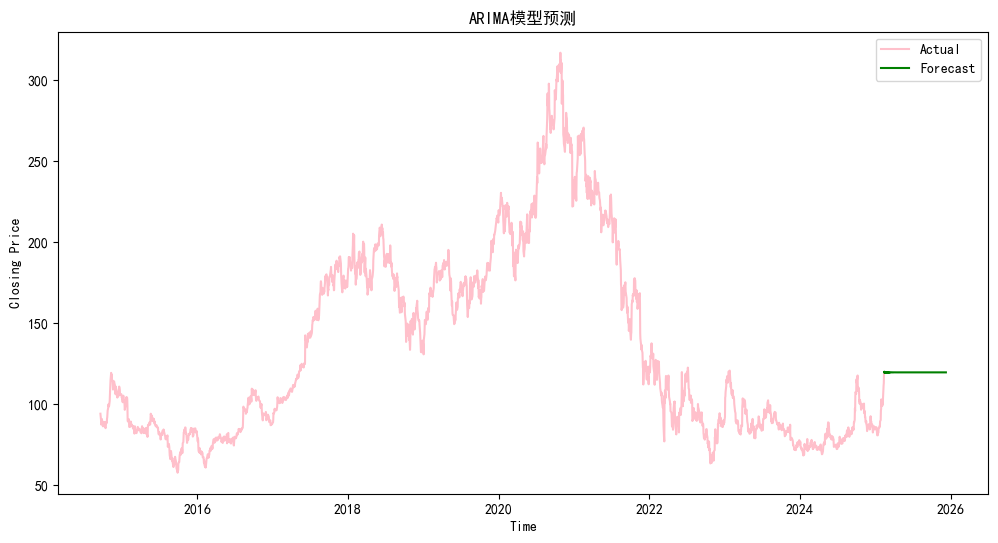

In [13]:
forecast = model_fit.forecast(steps=300)
plt.figure(figsize=(12,6))
plt.plot(data.index, data["Close"], label="Actual", color="pink")
plt.plot(pd.date_range(start=data.index[-1], periods=300, freq="D"), forecast, label="Forecast", color="green")
plt.xlabel("Time")
plt.ylabel("Closing Price")
plt.title("ARIMA模型预测")
plt.legend()
plt.show()